# Recreation of machine learning model across metals and species

<font color='red'>
    Gaussian Process regression (automated hyperparameter opt) with:
    
    Species only bond counts
    CHCHCO, OH, C adsorption energies as metal descriptions

</font>

A. J. Chowdhury, W. Yang, E. Walker, O. Mamun, A. Heyden, and G. A. Terejanu, “Prediction of Adsorption Energies for Chemical Species on Metal Catalyst Surfaces Using Machine Learning,” J. Phys. Chem. C, vol. 122, no. 49, pp. 28142–28150, 2018, doi: 10.1021/acs.jpcc.8b09284.

In [58]:
import sklearn.gaussian_process as gp
import sklearn.model_selection as ms
import sklearn.metrics as metrics
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

## Grab the data set of energies and features from the authors

located in ./Review_SI, which is the supporting information folder directly supplied by the authors

In [2]:
features_raw = pd.read_csv('./Review_SI/inputfiles_cm_bob_with_bondcounts/CM_BoB_with_MetalExcluded/propionic_CM_exclMetals_power_1.csv', index_col=0)

In [3]:
## ensure all species are capitalized
features_raw['1'] = features_raw['1'].apply(lambda s: s.upper())
features_raw

,0,1,2,3,4,c_m,o_m,c_c,c_h,c_o,...,6,7,8,9,10,11,12,13,14,15
0,Pd,CH2C,4.803900,0.612100,2.13400,2,0,1,2,0,...,11.478379,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,-0.038058,-0.672493
1,Pd,CH2CH,4.803900,0.612100,2.13400,2,0,1,3,0,...,12.859874,0.000000,0.000000,0.00000,0.0,0.0,0.000000,-0.046198,-0.254498,-0.690152
2,Pd,CH2CH2,4.803900,0.612100,2.13400,2,0,1,4,0,...,13.067864,0.040784,0.000000,0.00000,0.0,0.0,0.000000,-0.125670,-0.400848,-0.847250
3,Pd,CH2CHCO,4.803900,0.612100,2.13400,3,1,2,3,1,...,44.860318,15.429075,6.314973,0.00000,0.0,0.0,0.000000,-0.045760,-0.312318,-0.769596
4,Pd,CH2CHCOOH,4.803900,0.612100,2.13400,2,0,2,3,2,...,46.239669,42.188038,14.461258,4.49599,0.0,0.0,-0.045615,-0.309747,-0.497297,-0.773652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,Cu,CO,5.934817,0.043217,4.10581,1,0,0,0,1,...,10.629872,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
204,Cu,CO2,5.934817,0.043217,4.10581,0,0,0,0,2,...,46.299128,2.814205,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
205,Cu,COOH,5.934817,0.043217,4.10581,1,0,0,0,2,...,45.140260,8.067038,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.000000,-0.463496
206,Cu,H2O,5.934817,0.043217,4.10581,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,-0.144065,-0.662200


In [4]:
labels_raw = pd.read_csv('./Review_SI/Energies/Energies_in_TableFormat.csv', index_col=0)
labels_raw

,Pd,Pt,Rh,Re,Ru,Cu,Ag,Ni
CH3CH2COOH,2.97107,3.096632,2.72217,2.59072,2.53976,2.973637,3.148816,3.03062
CH3CHCOOH,3.58645,3.488302,3.42231,3.30618,3.04576,3.940157,4.268496,3.59558
CH3CCOOH,4.27229,4.049232,3.68385,3.33508,3.30980,4.780567,5.642976,4.06085
CH2CHCOOH,3.94833,3.820652,3.81269,3.23614,3.29483,4.549847,4.647756,3.86939
CHCHCOOH,4.74547,4.403232,4.16585,3.52616,3.69583,5.254597,5.954526,4.43884
CH3CH2CO,2.86032,2.862232,2.72947,2.76757,2.58968,3.752517,4.132906,2.98426
CH3CHCO,3.60693,3.219982,3.27008,3.14260,3.00702,4.593117,4.686186,3.66871
CH3CCO,3.96214,3.585952,3.64442,3.07664,3.36371,5.001457,5.462066,3.85703
CH2CHCO,4.02901,3.863752,3.61777,3.14080,3.35454,5.301757,5.777366,4.11394
CHCHCO,4.80390,4.336672,4.26048,3.47529,3.64120,5.934817,6.828056,4.65592


## Work the data to be ready for machine learning
First, append the label (Eads of a species unto a metal) into the features table

In [5]:
def get_Eads(row):
    metal, species = tuple(row)
    Eads = labels_raw.loc[species, metal]
    return Eads

In [6]:
data_raw = features_raw.copy()
data_raw['Eads'] = features_raw[['0', '1']].apply(get_Eads, axis=1, raw=True)

Next, drop unnecessary columns

In [7]:
## Function to test for column names as integers
def RepresentsInt(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False

In [8]:
data = data_raw.copy()
## drop unnecessary columns so that we have just features and labels
c_drop = ['0', '1', 'c_m', 'o_m']
for c in data_raw.columns:
    if RepresentsInt(c):
        if int(c) > 4:
            c_drop.append(c)
            
data.drop(c_drop, axis=1, inplace=True)
data.rename(mapper={'2': 'Eads_CHCHCO', '3': 'Eads_OH', '4': 'Eads_C'}, axis=1, inplace=True)
data

,Eads_CHCHCO,Eads_OH,Eads_C,c_c,c_h,c_o,o_h,Eads
0,4.803900,0.612100,2.13400,1,2,0,0,2.536120
1,4.803900,0.612100,2.13400,1,3,0,0,2.273240
2,4.803900,0.612100,2.13400,1,4,0,0,1.472440
3,4.803900,0.612100,2.13400,2,3,1,0,4.029010
4,4.803900,0.612100,2.13400,2,3,2,1,3.948330
...,...,...,...,...,...,...,...,...
203,5.934817,0.043217,4.10581,0,0,1,0,2.188127
204,5.934817,0.043217,4.10581,0,0,2,0,2.361527
205,5.934817,0.043217,4.10581,0,0,2,1,2.636047
206,5.934817,0.043217,4.10581,0,0,0,2,-0.210283


This is the full dataset of species bond counts, metal adsorption descriptors, and labels (Eads of some species on some metal

## Machine learning

The authors split the above set of 208 examples of species/metal adsorption energies into development and testing by some ratio. The development set was used to optimize and train the GP model, while the predictive ability was evaluated on the test set.

This was repeated for an unjustifiable reason 100 times, each time shuffle the set, so that every individual datum had been statistically seen by many of the individual trianing models. Averageing over these removes information about how the model generalizes to data that it has never seen based on the training set. This strategy masks the effect of the small dataset.

In [17]:
## define the kernel and model: gaussian/squared exponential/radial basis function
kernel = gp.kernels.RBF()
gpr = gp.GaussianProcessRegressor(kernel=kernel,random_state=0)

In [10]:
## pop the labels
features = data.copy()
labels = features.pop('Eads')

In [32]:
## split into train, test
_ = ms.train_test_split(features, labels, test_size=88, random_state=0)
features_dev, features_test, labels_dev, labels_test = _

### Evaluate the effect of training set size
If the task is valid, eg. we are learning a generalizable mode, the validation score will raise to a plateau. If there is not enough data in the training set, it will be low and raising, if there is enough, it will be non changing at the plateau. 

If however the task is structured in a poor way, ie. the model is not a generalizable task, we will see a DECREASE in validation score as training size increases

In [33]:
%%capture
## train the model CV to avaluate dataset size
lc = ms.learning_curve(gpr, features_dev, labels_dev)

In [50]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 13}

matplotlib.rc('font', **font)

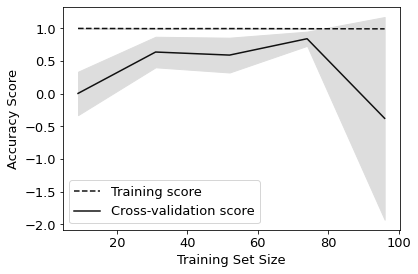

In [52]:
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = lc
# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.legend(loc='lower left')
fig = plt.gcf()
fig.savefig('review_learning_curve.png', dpi=300, bbox_inches='tight')

### Train a  single model to evaluate predictions
Let's look at the prediction curve

In [53]:
## fit to dev set
gpr.fit(features_dev, labels_dev)

GaussianProcessRegressor(kernel=RBF(length_scale=1), random_state=0)

In [54]:
## use to predict
predictions, stds = gpr.predict(features_test, return_std=True)

/opt/anaconda3/envs/prelim_review/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [55]:
## create pandas dataframe of results
d = {
    r'True $E_{ads}$ [eV]': labels_test.to_numpy(),
    r'Predicted $E_{ads}$ [eV]': predictions,
    r'Prediction Confidence (1 STD) [eV]': stds
    
}

predict_table = pd.DataFrame.from_dict(d,orient='index').transpose()
predict_table

,True $E_{ads}$ [eV],Predicted $E_{ads}$ [eV],Prediction Confidence (1 STD) [eV]
0,4.695726,1.593744,0.965108
1,1.086350,1.339889,0.470260
2,3.752517,2.699078,0.740342
3,5.777366,5.462067,0.000267
4,4.049232,3.820652,0.000000
...,...,...,...
83,4.165850,4.773288,0.466750
84,3.606930,3.464473,0.470501
85,3.335080,3.236140,0.000563
86,1.230200,1.186499,0.448493


Create a plot:

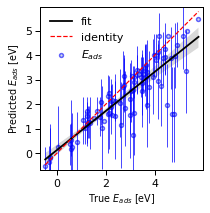

In [57]:
minl, maxl = np.min(labels_test.to_numpy()), np.max(labels_test.to_numpy())

sns.set_context("paper", font_scale=1)
fig, ax = plt.subplots(figsize=(3,3))

g = sns.regplot(data = predict_table, x=r'True $E_{ads}$ [eV]', y=r'Predicted $E_{ads}$ [eV]', 
                scatter='True',
                color='blue', x_ci='sd', label=r'$E_{ads}$',
                scatter_kws=dict(alpha=.6, linewidths=1.5, facecolor='lightsteelblue', s=15),
                line_kws=dict(color='k', label='fit'), ax=ax)

ax.plot([minl, maxl], [minl,maxl], c='red', linestyle='dashed', label='identity')
ax.legend(loc='upper left', frameon=False, ncol=1, fontsize=11)
ax.set_aspect('equal')
plt.xlim(minl-.2, maxl+.2)
plt.ylim(minl-.2, maxl+.2)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
ax.errorbar(predict_table[r'True $E_{ads}$ [eV]'], predict_table[r'Predicted $E_{ads}$ [eV]'], 
            yerr=2*stds, fmt='none', color='b', linewidth=.7)
plt.savefig('predict_plot_review.png', bbox_inches='tight', dpi=300)

The mean average error

In [59]:
metrics.mean_absolute_error(predict_table[r'True $E_{ads}$ [eV]'], predict_table[r'Predicted $E_{ads}$ [eV]'])

0.525097730226847